# 📗 SVD - Practical Applications: RGB Image Compression and Filters

<img src="https://drive.google.com/uc?export=download&id=1jsIXRsEYZ6GprQo4r0FwnmUXJjl1iqbr"
     alt="RGB image with different compression orders."
     title="RGB image with different compression orders.">

# 0 - Introduction

In this notebook, I will show you how to use the **Singular Value Decomposition (SVD)** in practical applications. The goal here is not to understand the decomposition method behind the calculation of the U, Σ and V matrices. We will first apply compression to a single gray channel image and then extend it to RGB. For the calculation of the SVD terms, we will use the method **linalg.svd** from *Numpy*.

*JPG* and *PNG* files already use their own type of compression. In order to remain logical in the approach, I use a *Bitmap (BMP)* file since it has no compression.

I will try to explain as best I can each of my steps in order to make it easier for beginners to understand, without becoming redundant for others. Please, do not hesitate to contact me if you have questions or suggestions.

**Note:** Real image compression actually uses other more efficient algorithms than SVD. SVD is rather used in statistics for PCA: https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales.

Nevertheless, I hope that you will learn something, or at least find artistic interest in it at the end of this Notebook. &#127912;

If you don't understand SVD, please watch the very well explained *YouTube* video from *Luis Serrano*: https://www.youtube.com/watch?v=DG7YTlGnCEo&ab_channel=Serrano.Academy.

You can also consult the *Wikipedia* page of SVD for more details: https://en.wikipedia.org/wiki/Singular_value_decomposition.

**Have a good reading!** &#128515;

# I - Getting Started

## I.a - Tools

We need a few imports:
- **numpy** to manipulate arrays, for linear algebra and calculate the SVD terms
- **PIL** to open our own image and make conversions
- **matplotlib.pyplot** for the displays
- **scipy** for fitting curves
- **tqdm** for visualizing the progress in a loop
- **warnings** for ignoring unimportant warnings

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

We can open the image with PIL that stores it into a *'PIL.JpegImagePlugin.JpegImageFile'* object. Then, we display it using Matplotlib.

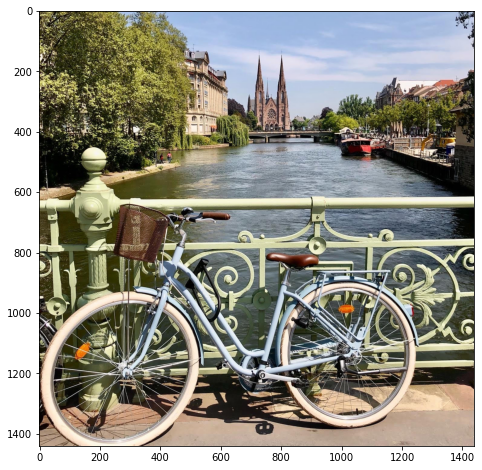

In [2]:
# Store the image
image = Image.open('../input/image-to-compress/strasbourg.bmp')

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

## I.b - Compression function for a single channel

We create a function with in inputs our image as a Numpy array and the compression order. The compression order goes from 1 to the length of the smallest border of the image. In our case, we have a square image so it goes until 1440. Order 1 is the most compressed (ligth file) whereas high orders are close to the original image (heavy file).

The function will return the compressed Numpy array of our image.

**Note: This function only works for a single channel (only gray, red, green or blue)**

In [3]:
def svd_compressor(image, order):
    """Returns the compressed image channel at the specified order"""
    
    # Create an array filled with zeros having the shape of the image
    compressed = np.zeros(image.shape)
    
    # Get the U, S and V terms (S = SIGMA)
    U, S, V = np.linalg.svd(image)
    
    # Loop over U columns (Ui), S diagonal terms (Si) and V rows (Vi) until the chosen order
    for i in range(order):
        Ui = U[:, i].reshape(-1, 1)
        Vi = V[i, :].reshape(1, -1)
        Si = S[i]
        compressed += (Ui * Si * Vi)
    
    return compressed

That's it!

# II - Compression of a single channel (gray image)

Now we first test our function with our image converted to gray. This will reduce the 3 RGB channels to a single gray channel.

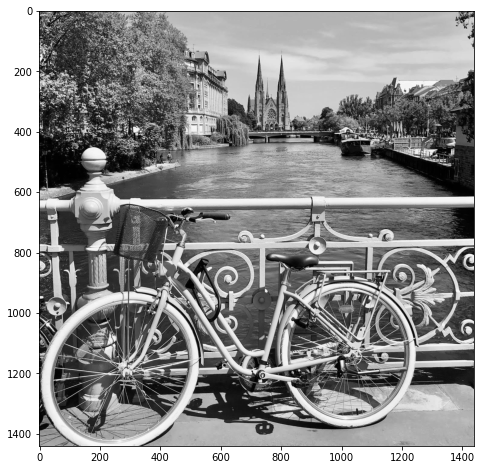

In [4]:
# Convert the image with PIL ('L' is the value for a single channel)
gray_image = image.convert('L')

# Display gray image
plt.figure(figsize=(8, 8))
plt.imshow(gray_image, cmap='gray')
plt.show()

100%|██████████| 10/10 [00:43<00:00,  4.30s/it]


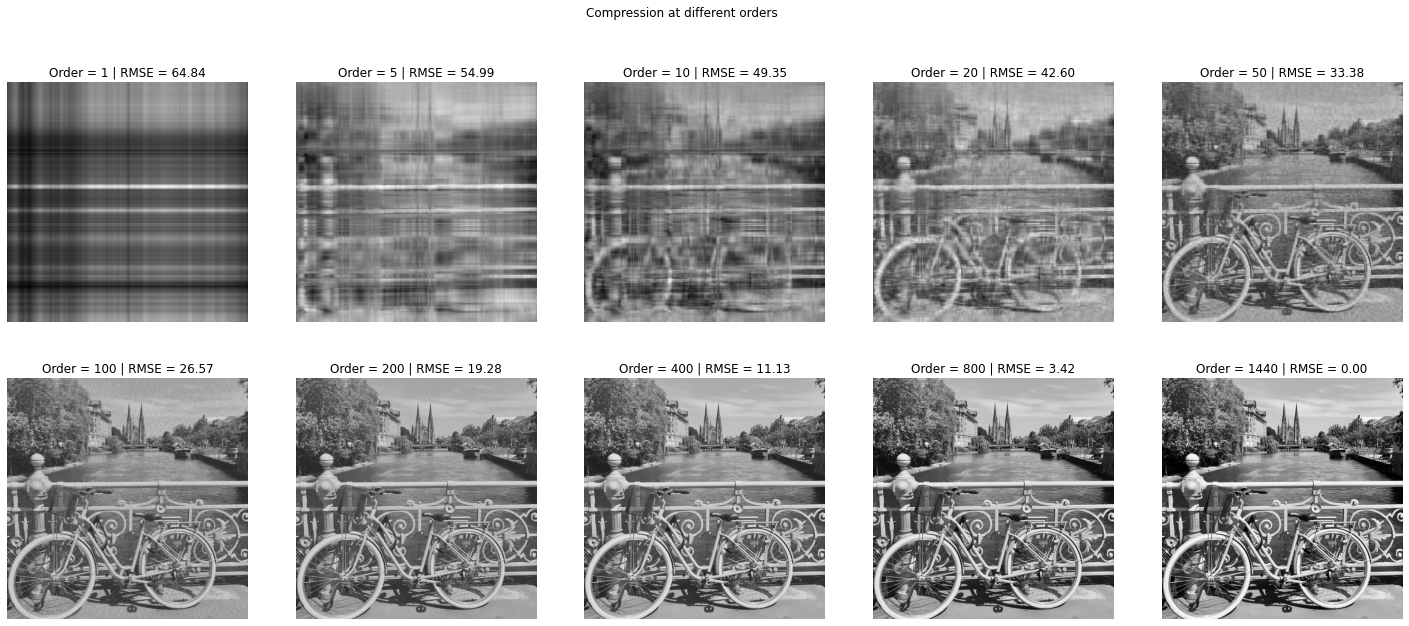

In [5]:
# Convert to Numpy array for the function
gray_image = np.array(gray_image)

orders = [1, 5, 10, 20, 50, 100, 200, 400, 800, 1440]
rmse = []

plt.figure(figsize=(25, 10))

for i in tqdm(range(len(orders))):
    
    # Use the compressor function
    order = orders[i]
    gray_comp = svd_compressor(gray_image, order)
    
    # Round the calculated values and convert them from float to int.
    gray_comp = np.around(gray_comp).astype(int)
    
    # Calculate RMSE
    rmse.append(np.sqrt(np.mean((gray_image - gray_comp)**2)))
    
    # Display the compressed gray image in the subplot
    plt.subplot(2, 5, i + 1)
    plt.title("Order = {} | RMSE = {:.2f}".format(order, rmse[i]))
    plt.axis('off')
    plt.imshow(gray_comp, cmap='gray')

plt.suptitle('Compression at different orders')
plt.show()

## II.a - Room Mean Squared Error (RMSE)

The **RMSE** was calculated previously for each order of compression. It gives us an indication of the difference between the values of pixels of the original image and those of the compressed image. We can thus observe how this value decreases when we increase the order of compression. This value reaches zero at the final order, which proves that the compressed image at order 1440 brings us back to the original image.

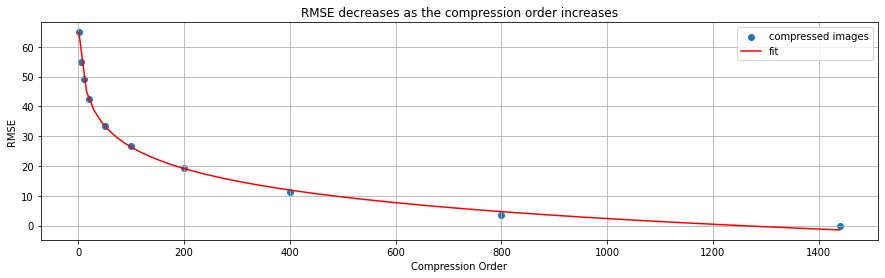

In [6]:
def f(x, a, b, c, d):
    return a * np.log(b * x + c) + d

x_fit = np.linspace(orders[0], orders[-1], 100)
params = curve_fit(f, orders, rmse)
y_fit = f(x_fit, *params[0])

plt.figure(figsize=(15, 4))
plt.scatter(orders, rmse, label="compressed images")
plt.plot(x_fit, y_fit, c='r', ls='-', label="fit")
plt.title("RMSE decreases as the compression order increases")
plt.xlabel("Compression Order")
plt.ylabel("RMSE")
plt.grid('on')
plt.legend()
plt.show()

## II.b - Compression Ratio

The goal of image compression is to reduce the size of the file. Let's calculate the **compression ratio** for each order.

For the original image, each pixel is encoded with a single byte per channel. For the compressed image, the information is stored in U, Σ and V. Then we can calculate the size regarding the order, the number of columns/rows used.

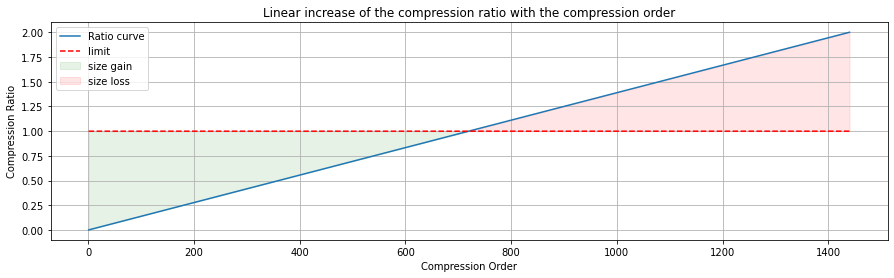

In [7]:
original_size = 1440 * 1440 * 1
orders = np.arange(1, 1440 + 1, 1)
compression_size = (1440 + 1 + 1440) * orders

compression_ratio = compression_size / original_size

plt.figure(figsize=(15, 4))

plt.plot(orders, compression_ratio, label="Ratio curve")
plt.plot(orders, np.ones((1440)), c='r', ls='--', label="limit")
plt.fill_between(orders, compression_ratio, 1, where=(orders < 720),
                 color='green', alpha=0.1, label="size gain")             
plt.fill_between(orders, compression_ratio, 1, where=(orders >= 720),
                 color='red', alpha=0.1, label="size loss")   
    
plt.title("Linear increase of the compression ratio with the compression order")
plt.xlabel("Compression Order")
plt.ylabel("Compression Ratio")
plt.grid('on')
plt.legend()
plt.show()

We see that it is completely useless to make such a compression after order 700. The size or the compressed images exceeds the original size. This is a limit of SVD compression. If we want a reasonnable amount of compression, it will always cost information.

# III - Compression of the RGB image

Failing to use SVD as a real useful tool for compression, let's see if we can use it on our RGB image to create cool filters. First let's try to perform the same compression as earlier on each of the three color channels.

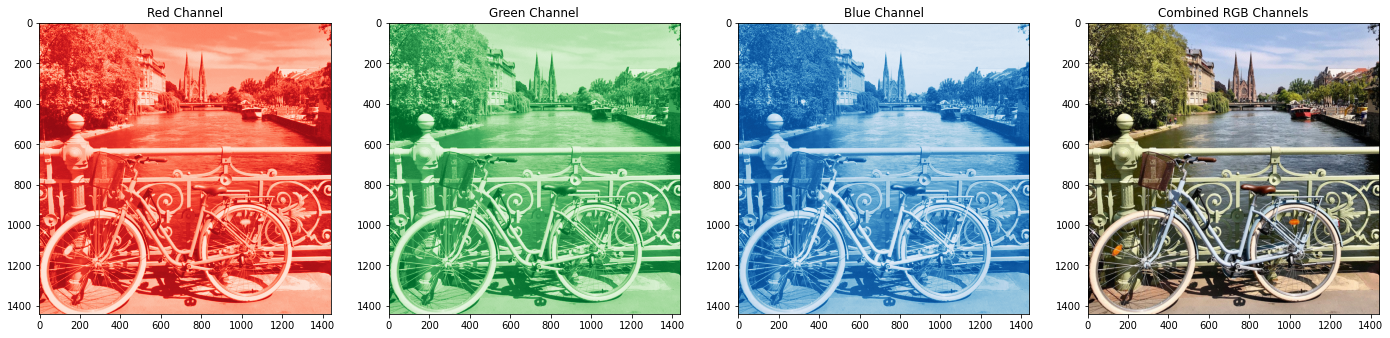

In [8]:
# Separation of the image channels
red_image = np.array(image)[:, :, 0]
green_image = np.array(image)[:, :, 1]
blue_image = np.array(image)[:, :, 2]

# Compression of each channel
order = 500
red_comp = svd_compressor(red_image, order)
green_comp = svd_compressor(green_image, order)
blue_comp = svd_compressor(blue_image, order)

# Recombinasion of the colored image
color_comp = np.zeros((np.array(image).shape[0], np.array(image).shape[1], 3))
color_comp[:, :, 0] = red_comp
color_comp[:, :, 1] = green_comp
color_comp[:, :, 2] = blue_comp
color_comp = np.around(color_comp).astype(int)

# Display of the 3 separated channels
plt.figure(figsize=(24, 8))
plt.subplot(141)
plt.imshow(red_comp, cmap='Reds_r')
plt.title("Red Channel")
plt.subplot(142)
plt.imshow(green_comp, cmap='Greens_r')
plt.title("Green Channel")
plt.subplot(143)
plt.imshow(blue_comp, cmap='Blues_r')
plt.title("Blue Channel")
plt.subplot(144)
plt.imshow(color_comp)
plt.title("Combined RGB Channels")
plt.show()

**Note:** I used matching colormaps to display the channels. In reality each channel is only an array of numbers and do not contain an intrinsic color. Also, I used the '_r' suffix in order to reverse the colormap from negative to positive.

100%|██████████| 10/10 [02:11<00:00, 13.12s/it]


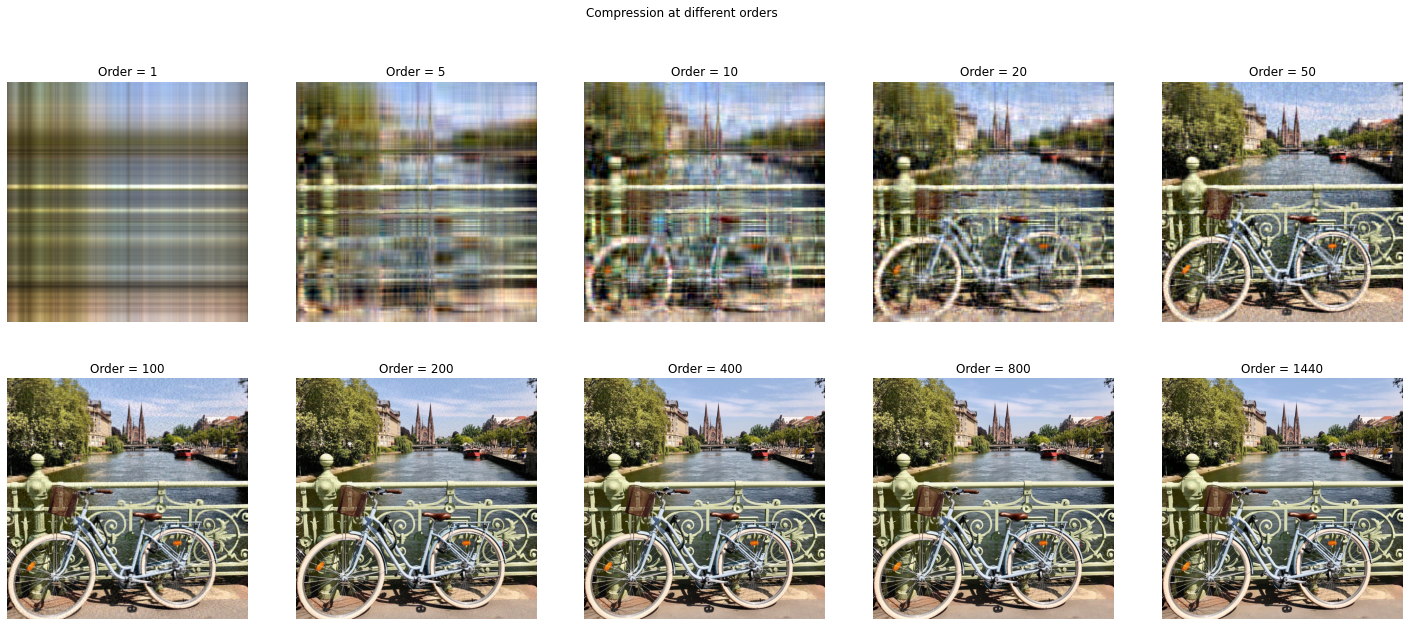

In [9]:
plt.figure(figsize=(25, 10))

orders = [1, 5, 10, 20, 50, 100, 200, 400, 800, 1440]

for i in tqdm(range(len(orders))):
    
    # Use the compressor function
    order = orders[i]
    red_comp = svd_compressor(red_image, order)
    green_comp = svd_compressor(green_image, order)
    blue_comp = svd_compressor(blue_image, order)
    
    # Combine images
    color_comp = np.zeros((np.array(image).shape[0], np.array(image).shape[1], 3))
    color_comp[:, :, 0] = red_comp
    color_comp[:, :, 1] = green_comp
    color_comp[:, :, 2] = blue_comp
    color_comp = np.around(color_comp).astype(int)
    
    # Display the compressed colored image in the subplot
    plt.subplot(2, 5, i + 1)
    plt.title("Order = {}".format(order))
    plt.axis('off')
    plt.imshow(color_comp)

plt.suptitle('Compression at different orders')
plt.show()

As earlier, we have been able to recover the image quality by increasing the compression order. Now, let's play a bit with the possibilities offered by SVD and try to enhance the picture style. We may find a real interesting purpose other than size reduction.

# IV - Playground

## IV.a - Uneven channel compression

I'm curious how would render an image whose different channels have been compressed differently from each other. We can just try!

In [10]:
# Color pallet
red_image = np.array(image)[:, :, 0]
green_image = np.array(image)[:, :, 1]
blue_image = np.array(image)[:, :, 2]

In [11]:
orders = [(200, 200, 1), (1, 200, 1), (1, 200, 200), (1, 1, 200), (200, 1, 200), (200, 1, 1)]
final_images = []

for order in tqdm(orders):
            
    red_channel = svd_compressor(red_image, order[0])
    green_channel = svd_compressor(green_image, order[1])
    blue_channel = svd_compressor(blue_image, order[2])
            
    # combine
    final_image = np.zeros((np.array(image).shape[0], np.array(image).shape[1], 3))
    final_image[:, :, 0] = red_channel
    final_image[:, :, 1] = green_channel
    final_image[:, :, 2] = blue_channel
    final_image = np.around(final_image).astype(int)
            
    final_images.append(final_image)

100%|██████████| 6/6 [00:45<00:00,  7.66s/it]


100%|██████████| 6/6 [00:00<00:00, 11.37it/s]


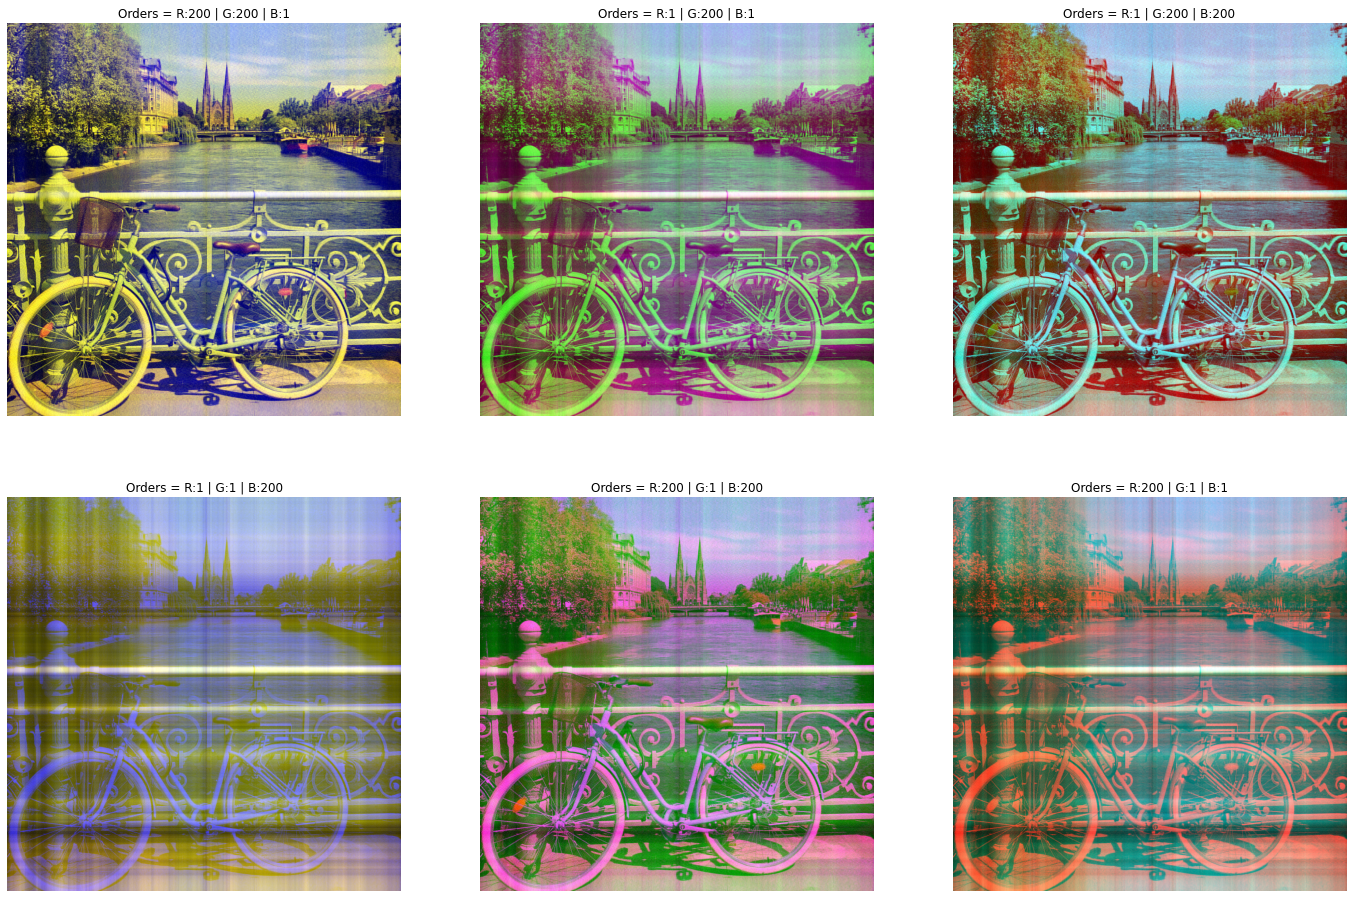

In [12]:
plt.figure(figsize=(24, 16))

for i in tqdm(range(len(final_images))):
    img = final_images[i]
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title("Orders = R:{} | G:{} | B:{}".format(*orders[i]))
    plt.axis('off')
    
plt.show()

The strong compression of one or two channels while keeping the quality of the others causes color imbalance according to the rule of additive color synthesis. Contrary to a pure decrease in the intensity of one of the channels, we observe these horizontal and vertical lines specific to the SVD. That could be used for an artistic purpose.

## IV.b - Black and White compression

PIL can convert our original image into an array of only zeros and ones. This results in a pur boolean image and we can try to use SVD compression on it.

100%|██████████| 8/8 [00:14<00:00,  1.86s/it]


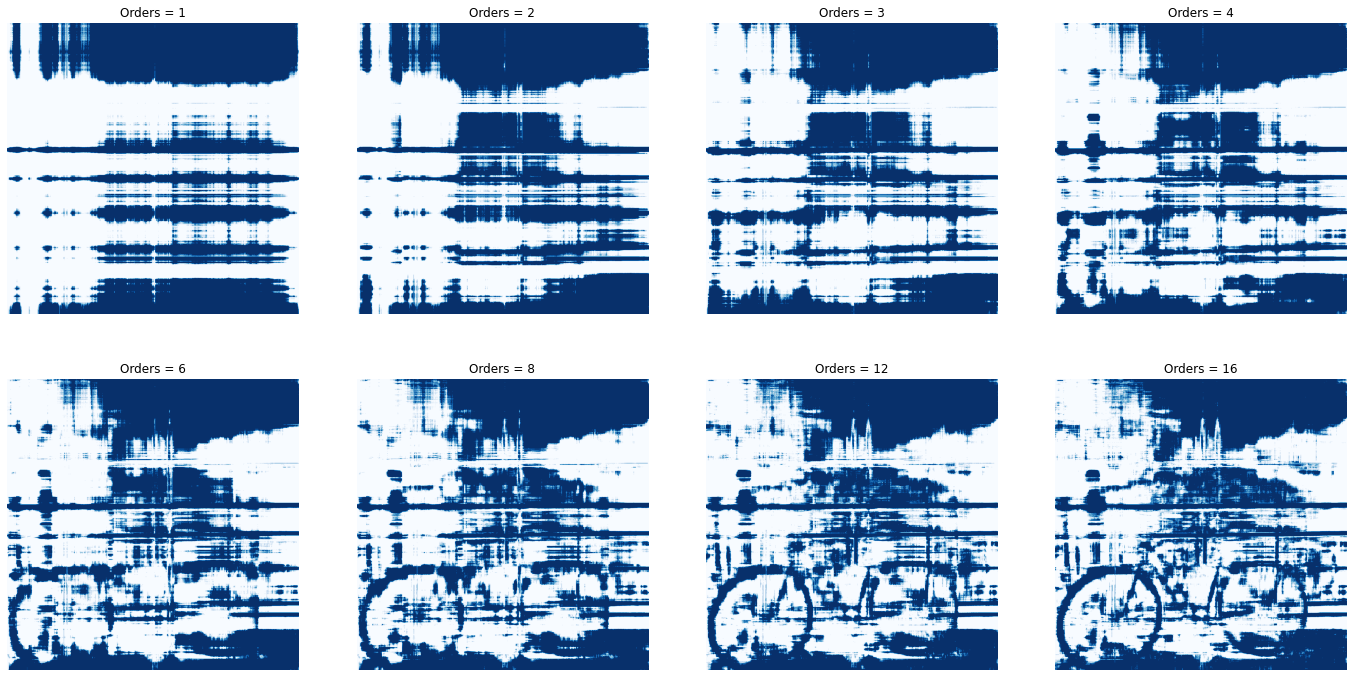

In [13]:
plt.figure(figsize=(24, 12))

boolean_image = np.array(image.convert('1'))
orders = [1, 2, 3, 4, 6, 8, 12, 16]

for i in tqdm(range(len(orders))):
    boolean_comp = svd_compressor(boolean_image, orders[i])
    boolean_comp = np.around(boolean_comp).astype(int)
    
    plt.subplot(2, 4, i + 1)
    plt.imshow(boolean_comp, cmap='Blues')
    plt.title("Orders = {}".format(orders[i]))
    plt.axis('off')
    
plt.show()

These images make me think of those of the Rorschach test. Here we can only recognize the bicycle after order 6. We could imagine a game on this principle in which the participants must find a word corresponding to the image as the order increases. I leave this idea to you if you ever want to take it back!

That was all for today, thank you so much for reading until the end!

**Have a nice day!** 😁